In [1]:
from fastai2.vision.all import *


In [2]:
df= pd.read_csv('train.csv')
df['Image']= 'Train Images/'+df['Image']

In [3]:
df.head()

,Image,Class
0,Train Images/image7042.jpg,Food
1,Train Images/image3327.jpg,misc
2,Train Images/image10335.jpg,Attire
3,Train Images/image8019.jpg,Food
4,Train Images/image2128.jpg,Attire


In [4]:
tfms = [Rotate(draw=10., p=0.5), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=0.5)]
comp = setup_aug_tfms([Rotate(draw=10., p=0.5), Zoom(draw=1.1, draw_x=0.5, draw_y=0.5, p=0.5)])#,RandomErasing(p=0.1, sh=0.2,max_count=1)])

In [5]:
datablk = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_x=ColReader(cols='Image'), 
#                  splitter=RandomSplitter(seed=42), 
                splitter=TrainTestSplitter(test_size=0.2, random_state=42), #, stratify=df['Class']),
                    
                 get_y=ColReader(cols='Class'),
                 item_tfms=Resize(80),
                 batch_tfms=comp )

In [6]:
datablk.summary(df)

Setting-up type transforms pipelines
0      Train Images/image7042.jpg    Food
1      Train Images/image3327.jpg    misc
2     Train Images/image10335.jpg  Attire
3      Train Images/image8019.jpg    Food
4      Train Images/image2128.jpg  Attire
...                           ...     ...
5978   Train Images/image2494.jpg    Food
5979   Train Images/image8015.jpg  Attire
5980   Train Images/image4975.jpg    Food
5981   Train Images/image1222.jpg    Food
5982   Train Images/image9635.jpg  Attire

[5983 rows x 2 columns]
Found 5983 items
2 datasets of sizes 4786,1197
Setting up Pipeline: ColReader -> PILBase.create
Setting up Pipeline: ColReader -> Categorize

Building one sample
  Pipeline: ColReader -> PILBase.create
    starting from
      Image    Train Images/image6131.jpg
Class                        Attire
Name: 1471, dtype: object
    applying ColReader gives
      Train Images/image6131.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=80x120
  Pipeline: ColReade

In [7]:
dls = datablk.dataloaders(df,num_workers=0)


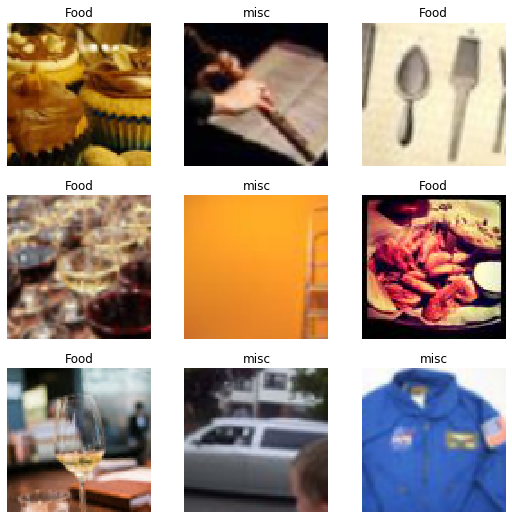

In [8]:
dls.show_batch()

In [9]:
auc =F1Score(average='weighted')

In [10]:
from torchvision.models.mobilenet import mobilenet_v2

In [11]:
from timm import create_model
def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int):
        return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut):
        return cut(model)
    else:
        raise NamedError("cut must be either integer or function")

In [12]:
arch='seresnext50_32x4d'


In [13]:
# body = create_timm_body('tf_efficientnet_b7_ns', pretrained=True)
body = create_timm_body(arch, pretrained=True)

nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

head = create_head(nf, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [14]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split,metrics=[accuracy,auc], opt_func=)#,wd=0.1)#.to_fp16()

In [15]:
def transfer_learn(learn:Learner, name:Path, device:torch.device=None):
    "Load model `name` from `self.model_dir` using `device`, defaulting to `self.dls.device`."
    if device is None: device = learn.dls.device
    learn.model_dir = Path(learn.model_dir)
    if (learn.model_dir/name).with_suffix('.pth').exists(): model_path = (learn.model_dir/name).with_suffix('.pth')
    else: model_path = name
    new_state_dict = torch.load(model_path, map_location=device)['model']
    learn_state_dict = learn.model.state_dict()
    for name, param in learn_state_dict.items():
        if name in new_state_dict:
            input_param = new_state_dict[name]
            if input_param.shape == param.shape:
                param.copy_(input_param)
            else:
                print('Shape mismatch at:', name, 'skipping')
        else:
            print(f'{name} weight of the model not in pretrained weights')
    learn.model.load_state_dict(learn_state_dict)
    return learn

In [16]:
save_clb=SaveModelCallback(monitor='accuracy', fname='model', every_epoch=False, with_opt=False)

In [17]:
learn.fine_tune(20, freeze_epochs=15,cbs=save_clb)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.775745,1.239090,0.619048,0.617866,00:39
1,1.573848,1.134676,0.661654,0.659177,00:35
2,1.427492,1.122287,0.670844,0.667223,00:34
3,1.321901,1.088358,0.672515,0.669229,00:34
4,1.284080,1.099943,0.675856,0.671225,00:34
5,1.197144,1.032972,0.693400,0.690430,00:33
6,1.067759,1.007829,0.680869,0.677780,00:34
7,0.986872,0.975247,0.680033,0.676801,00:34
8,0.916069,0.929533,0.712615,0.706314,00:34
9,0.880912,0.919704,0.706767,0.698361,00:34


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.774693,0.876447,0.715121,0.708257,00:46
1,0.746245,0.860852,0.721804,0.716303,00:45
2,0.728856,0.857732,0.730159,0.724807,00:45
3,0.721208,0.854051,0.729323,0.723141,00:45
4,0.692410,0.854926,0.730994,0.727246,00:45
5,0.688502,0.861697,0.733500,0.729893,00:45
6,0.667250,0.853392,0.741855,0.737675,00:45
7,0.655024,0.851926,0.741855,0.739197,00:45
8,0.622063,0.849496,0.742690,0.739134,00:45
9,0.604662,0.851397,0.746032,0.742788,00:45


In [ ]:
learn.fine_tune(40, cbs=save_clb)

In [ ]:
learn.fine_tune(40, cbs=save_clb)

In [ ]:
learn.freeze()
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(3e-2))

In [ ]:
learn.fit_one_cycle(5, slice(3e-2))

In [ ]:
learn.save('freeze_10_epochs')

In [ ]:
learn.fit_one_cycle(5, slice(3e-2))

In [ ]:
learn.save('freeze_15_epochs')

In [ ]:
learn = transfer_learn(learn, 'freeze_15_epochs')

In [ ]:
learn.load('freeze_15_epochs')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,slice(3e-3))

In [ ]:
learn.save('Unfreeze_5_epochs')

In [ ]:
learn.fit_one_cycle(5, slice(3e-3))

In [ ]:
learn.save('Unfreeze_10_epochs')

In [ ]:
learn.load('Unfreeze_10_epochs')

In [ ]:
learn.fit_one_cycle(5, slice(3e-3))

In [ ]:
# learn=cnn_learner(dls,densenet161,metrics=[accuracy,auc],wd=0.1)#.to_fp16()

In [ ]:
learn.fit_one_cycle(n_epoch=10)

In [ ]:
learn.fit_one_cycle(n_epoch=10)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(n_epoch=10,lr_max=1e-2)

In [18]:
test_df = pd.read_csv('test.csv')
sub_df=test_df.copy()
test_df['Image']='Test Images/'+test_df['Image']


In [19]:
tst_dl = dls.test_dl(test_df)


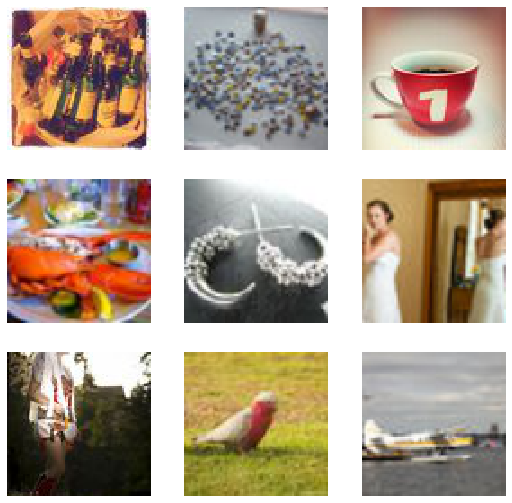

In [20]:
tst_dl.show_batch()

In [21]:
preds,_=learn.get_preds(dl=tst_dl)

learn.summary()

In [22]:
# learn_1=learn.to_fp32()

In [23]:
preds,a=learn.tta(dl=tst_dl,n=8)

In [24]:
sub_df['Class']=preds.argmax(axis=-1)
sub_df['Class']=sub_df['Class'].apply(lambda x : dls.vocab[x])

In [25]:
sub_df.to_csv(f'{arch}_wd0_tta8.csv',index=False)

In [ ]:
sub_df['Class'].hist()

In [ ]:
sub_df['Class'].value_counts()

In [ ]:
df['Class'].value_counts()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.top_losses()

In [ ]:
vals,idxs=interp.top_losses()

In [ ]:
len(idxs)

In [ ]:
preds_val,a=learn.get_preds()

In [ ]:
actual_val=dls.valid_ds.items['Class'].apply(lambda x : ds.categorize(x).item())

In [ ]:
df_1=pd.DataFrame({'actual':actual_val,
             'preds': a.numpy()})

In [ ]:
df_1[df_1['actual']==df_1['preds']]

In [ ]:
accuracy(preds_val,actual_val)

# Batch Scheduling 

2 Times Hard Batch 
1 Time Easy batch


In [ ]:
len(dls.valid_ds[a.numpy()!=actual_val])